# IMDB Movie Review Classification Assignment

## Data Analysis

In [1]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [2]:
import os

# List files
print(os.listdir())

['.config', 'IMDB Dataset.csv', 'sample_data']


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
review       0
sentiment    0
dtype: int64


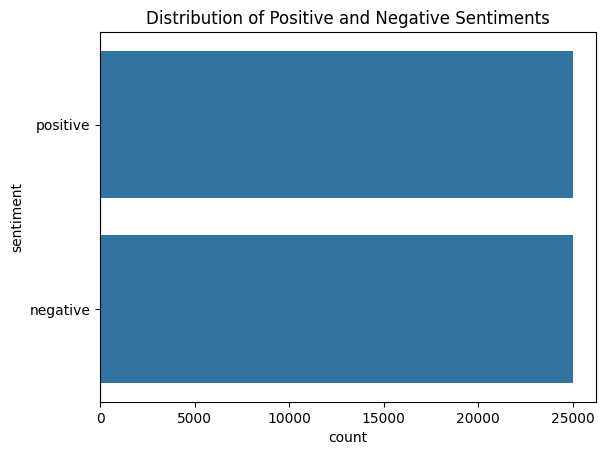

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Load the dataset
data = pd.read_csv('IMDB Dataset.csv')

# Display first few rows
print(data.head())

# Check for any missing values
print(data.isnull().sum())

# Plot the distribution of the sentiments
sns.countplot(data['sentiment'])
plt.title('Distribution of Positive and Negative Sentiments')
plt.show()

In [6]:
# Map the sentiment to binary values
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Tokenization and Padding
MAX_NUM_WORDS = 10000  # We'll use the top 10,000 most frequent words
MAX_SEQUENCE_LENGTH = 250  # Maximum length of review sequences

# Tokenizer to convert text to sequences of integers
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data['review'])

# Convert the reviews to sequences
sequences = tokenizer.texts_to_sequences(data['review'])
word_index = tokenizer.word_index

# Pad the sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Extract target labels
y = data['sentiment'].values

# Split data into training, validation, and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into training and validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Show sample of tokenized and padded data
print("Sample review sequence:", X_train[0])
print("Corresponding sentiment:", y_train[0])

Sample review sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   16   54 2103    5    1  150
   33   29  271   20   78  367    1  437   64   13   21   52   69 2177
    1   17 2097   16    3   78    3  947  155  219 1942    3  186 4102
  520  122    1 1211   18   91 1057  897    5 4552 1801  228    4  108
  979   16   32 1099  168  547    4  102    2   73   89  118  135  366
    1 1801  228   23   53    9  512   41   12   33   23    1  674   35
  853 1856    1 4102  650    2    1   64 4473   36   46    7    7  136
    1   64  124 1183   53   30   12  220    9   62  2

In [9]:
# Build the LSTM model
model = Sequential()

# Embedding layer with the input_shape specified
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Additional Dropout layer
model.add(Dropout(0.5))

# Output layer for binary classification (positive/negative sentiment)
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,559,681 (5.95 MB)

 Trainable params: 1,559,681 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Learning rate optimization callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.6658 - loss: 0.5706 - val_accuracy: 0.8419 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 590s 1s/step - accuracy: 0.8933 - loss: 0.2770 - val_accuracy: 0.8869 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - accuracy: 0.9221 - loss: 0.2084 - val_accuracy: 0.8825 - val_loss: 0.3042 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 581s 1s/step - accuracy: 0.9446 - loss: 0.1557 - val_accuracy: 0.8915 - val_loss: 0.3065 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.9645 - loss: 0.1067 - val_accuracy: 0.8841 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.9730 - loss: 0.0848 - val_accuracy: 0.8810 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.9695 - loss: 0.

313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 265ms/step - accuracy: 0.8794 - loss: 0.4995
Test Accuracy: 0.8762999773025513


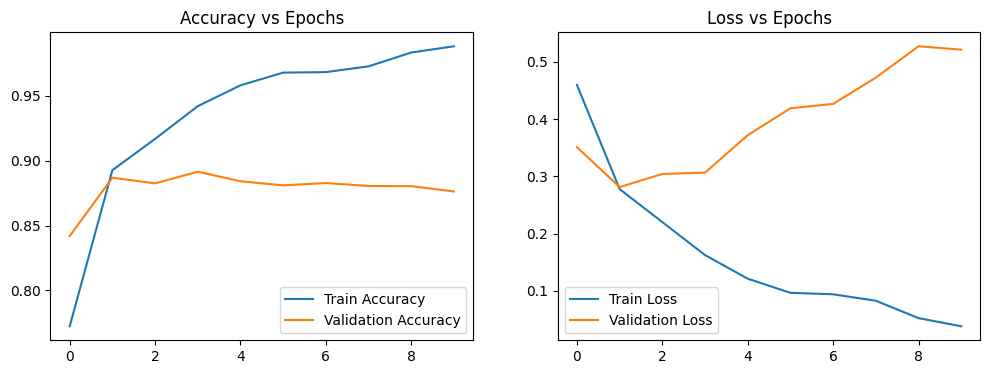

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step


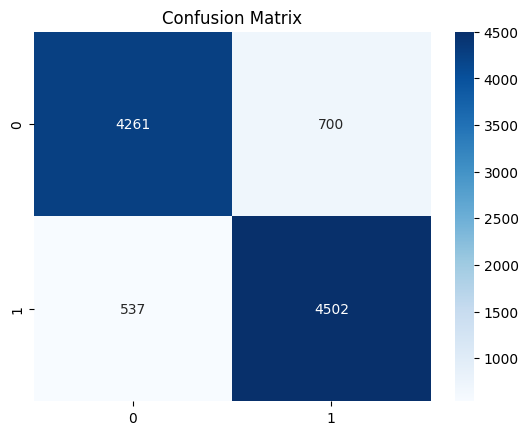

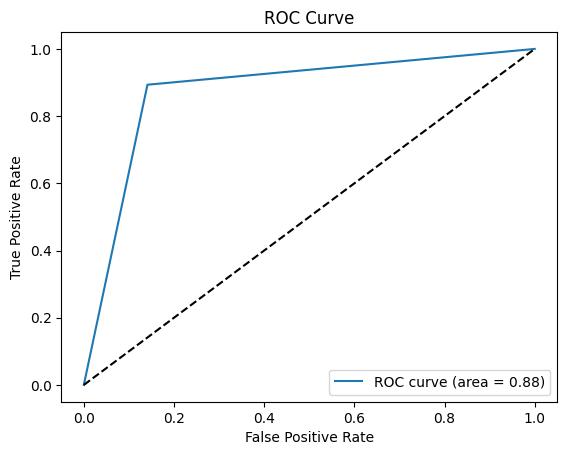

In [11]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot accuracy/loss vs. epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Find and plot incorrect predictions
incorrect_indices = np.where(y_test != y_pred.reshape(-1))[0]

for i in range(5):  # Show 5 incorrect predictions
    idx = incorrect_indices[i]
    print(f"Review: {data['review'].iloc[idx]}")
    print(f"True Sentiment: {y_test[idx]}, Predicted Sentiment: {y_pred[idx][0]}")
    print("="*80)

Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

## Write Up

**Overview of Assignment**

The goal of our assignment was to build a text classification model that uses the "IMDB Movie Reviews" dataset to predict the sentiment (positive / negative) of movie reviews. It is a binary classification task and the model has to learn to distinguish between positive and negative reviews based on the text of the reviews. In our project we preprocess the data, build a neural network using LSTM, train the model, and also evaluate it's performance on unseen test data.

**Description of Data**

The dataset we have contains 50,000 movie reviews. The reviews are evenly split, 25,000 positive and 25,000 negative. Each review is either labeled, positive (1), or negative (0). The reviews are transformed into sequences of integer indices, with each index corresponding to a word in the vocabulary.

**Summary of Methods**

The methods we used to complete our project involved the following.

1. Data Preprocessing: Reviews were preprocessed by tokenizing the text and converting it into sequences of integers using tokenizer. Then we padded the sequences to fixed length (250 words), this we did to ensure uniform input size for the neural network. By doing this it allows each review to be represented as a sequence of numerical values corresponding to words in the datasets vocabulary.

2. Model Architecture: For our text classification we used a bidirectional LSTM (Long Short-Term Memory). We did that because LSTMs are well suited for dequential data, like the text / reviews that we have for our project, this is due to their ability to capture dependencies between words across the sequence. We included a embedding layer to convert the words into dense vector representations, followed by the bidirectional LSTM layer to capture context from both directions in the text. Also, we included a dropout layer to try and prevent overfitting and fully connected layers for the final classification.

3. Training and evaluation: Our model was trained on the training set and then validated on a seperate validation set. The loss function is a binary cross-entropy , and our optimizer is Adam. Learning rate optimization is done using the "ReduceLROnPlateau" callback, it reduces the learning rate if the validation loss stops improving. The model was trained for 10 epochs, monitoring the accuracy and loss throughout the training.

**Summary of Model**

Key components of our model:

*The Embedding Layer* - converts words into dense vectors of size 128.

*Bidirectional LSTM Layer* - 128 unit LSTM layer, bidirectional to capture context from both past and future sequences in the text.

*Dropout Layers* - Two dropout layers with a rate of 0.5 to reduce overfitting

*Dense Layers* - 64 units and ReLu activation, followed by a final dense layer with 1 unit for binary classification.

The model architecture resulted in a total of **1,559,681 trainable parameters**.

**Analysis of Results**

Overall the model performed well on the training and testing data, but there was some overfitting observed, as we can see with the increasing gap between training and validation accuracy in the later epochs. Lets go more into detail:

*Training Accuracy* - Model achieved a training accuracy of 98.94% by the end of the 10 epochs.

*Validation Accuracy* - Around 88%, this indicates that the model was starting to overfit the data.

*Test Accuracy* - 87.63% which is a decent result, considering the complexity of our task.

*ROC Curve and AUC* - 0.88 which shows that our model has a good ability of distinguishing between the two classes.

*Incorrect Predictions* - As we looked at the incorrect predictions we can see that the model can struggle with nuanced languages or sarcasm, we can see that with the positive review of the show "Oz", but our model classified it as negative.
